In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [2]:
from google.colab import files

uploaded = files.upload()


Saving aml_tcga_gdc_clinical_data.csv to aml_tcga_gdc_clinical_data.csv


## Description des données

Les données cliniques ont été fournies au format tabulé (.tsv).  
Une attention particulière a été portée au séparateur lors de l’import afin d’éviter des erreurs de parsing.


In [3]:
#chargement des données
df = pd.read_csv('aml_tcga_gdc_clinical_data.csv', sep="\t") # séparateur de tabulations


#Aperçu des premières lignes
print("Aperçu des premières lignes :")
print(df.head())

#Dimensions et types de colonnes
print("\nDimensions du DataFrame :")
print(df.shape)

print("\nTypes des colonnes :")
print(df.dtypes)

Aperçu des premières lignes :
       Study ID    Patient ID        Sample ID  Diagnosis Age  Biopsy Site  \
0  aml_tcga_gdc  TCGA-AB-2802  TCGA-AB-2802-03             50  Bone Marrow   
1  aml_tcga_gdc  TCGA-AB-2803  TCGA-AB-2803-03             61  Bone Marrow   
2  aml_tcga_gdc  TCGA-AB-2804  TCGA-AB-2804-03             30  Bone Marrow   
3  aml_tcga_gdc  TCGA-AB-2805  TCGA-AB-2805-03             76  Bone Marrow   
4  aml_tcga_gdc  TCGA-AB-2806  TCGA-AB-2806-03             46  Bone Marrow   

              Cancer Type    Cancer Type Detailed  \
0  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
1  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
2  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
3  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
4  Acute Myeloid Leukemia  Acute Myeloid Leukemia   

   Last Communication Contact from Initial Pathologic Diagnosis Date  \
0                                                NaN                   
1                                     

Les valeurs manquantes sont inspectées variable par variable afin d’évaluer la qualité des données et d’anticiper les stratégies de prétraitement.


In [4]:
missing_values = df.isnull().sum().sort_values(ascending=False)

print("Valeurs manquantes par colonne :")
missing_values


Valeurs manquantes par colonne :


,0
Last Communication Contact from Initial Pathologic Diagnosis Date,132
Mutation Count,129
TMB (nonsynonymous),128
Death from Initial Pathologic Diagnosis Date,80
Overall Survival (Months),12
Ethnicity Category,3
Race Category,2
Patient Primary Tumor Site,1
Biopsy Site,1
Study ID,0


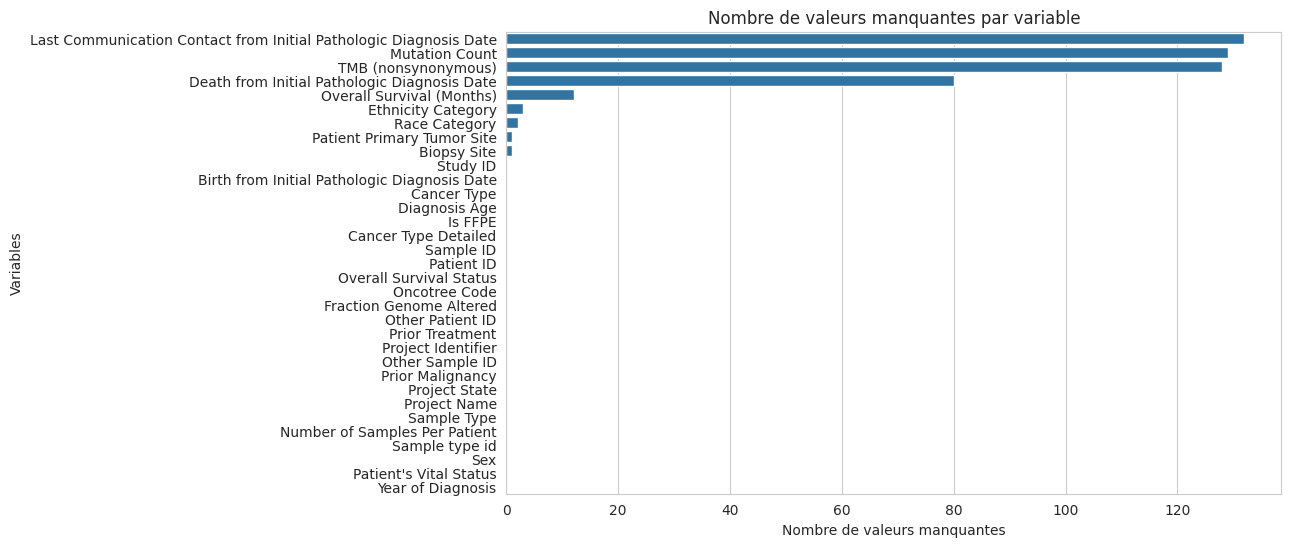

In [5]:
# représentation graphique
plt.figure(figsize=(10,6))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title("Nombre de valeurs manquantes par variable")
plt.xlabel("Nombre de valeurs manquantes")
plt.ylabel("Variables")
plt.show()

## Analyse des valeurs manquantes

Certaines variables présentent un nombre important de valeurs manquantes, notamment les variables temporelles (dates de contact, date de décès) et certaines variables biologiques (TMB, mutation count).  
Ces absences sont cohérentes avec le contexte clinique (patients vivants, examens non réalisés) et seront prises en compte lors de l’étape de prétraitement.


La variable cible (Overall Survival Status) présente un certain déséquilibre, ce qui devra être pris en compte lors de l’évaluation des modèles. La distribution de la variable cible montre un déséquilibre de classes modéré, avec environ 66,5 % de patients décédés et 33,5 % de patients vivants.
Ce déséquilibre sera pris en compte lors de l’évaluation des modèles, notamment à travers des métriques adaptées au contexte clinique.

In [6]:
# Distribution de la variable cible (target)
df["Overall Survival Status"].value_counts(normalize=True)


,proportion
Overall Survival Status,
1:DECEASED,0.665
0:LIVING,0.335


Identification des variables clés qui semblent associées au statut de survie.

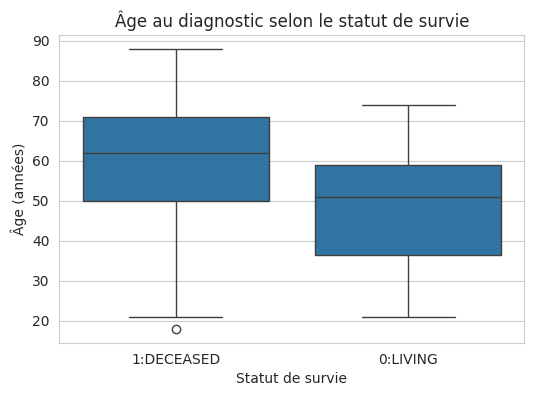

In [7]:
# Analyse des variables clés en lien avec la variable cible

# age au diagnostic (=variable numérique)
plt.figure(figsize=(6,4))
sns.boxplot(
    x='Overall Survival Status',
    y='Diagnosis Age',
    data=df
)
plt.title("Âge au diagnostic selon le statut de survie")
plt.xlabel("Statut de survie")
plt.ylabel("Âge (années)")
plt.show()



L’analyse exploratoire montre que les patients décédés présentent un âge médian au diagnostic plus élevé que les patients vivants. Cette observation est cliniquement cohérente avec le pronostic défavorable généralement associé à l’âge avancé en leucémie aiguë myéloïde. L’âge au diagnostic apparaît ainsi comme une variable pertinente pour la modélisation.

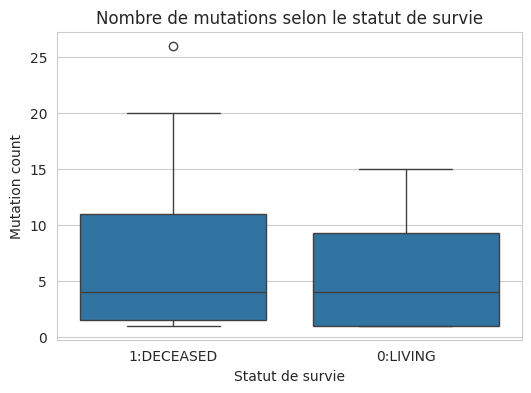

In [8]:
# nombre de mutations (=variable numérique)
plt.figure(figsize=(6,4))
sns.boxplot(
    x='Overall Survival Status',
    y='Mutation Count',
    data=df
)
plt.title("Nombre de mutations selon le statut de survie")
plt.xlabel("Statut de survie")
plt.ylabel("Mutation count")
plt.show()


Les patients décédés présentent globalement un nombre de mutations plus élevé, avec une dispersion plus importante et la présence de valeurs extrêmes. Cette observation suggère qu’une charge mutationnelle élevée pourrait être associée à un pronostic défavorable, en lien avec une instabilité génomique accrue.

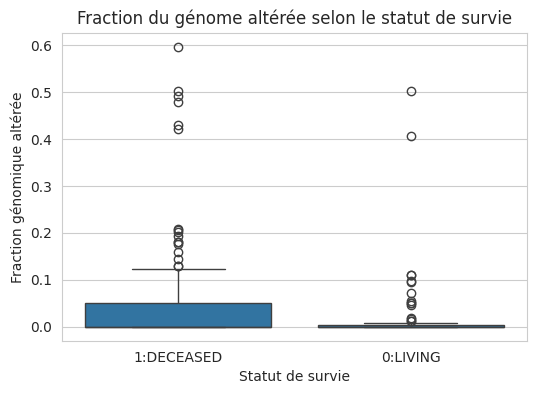

In [9]:
# fraction du génome altéré (=variable numérique)
plt.figure(figsize=(6,4))
sns.boxplot(
    x='Overall Survival Status',
    y='Fraction Genome Altered',
    data=df
)
plt.title("Fraction du génome altérée selon le statut de survie")
plt.xlabel("Statut de survie")
plt.ylabel("Fraction génomique altérée")
plt.show()


La fraction du génome altérée est globalement plus élevée chez les patients décédés, avec une dispersion importante et la présence de valeurs extrêmes. Cette observation suggère qu’une instabilité génomique accrue pourrait être associée à un pronostic défavorable, ce qui est cohérent avec les connaissances cliniques en hématologie.

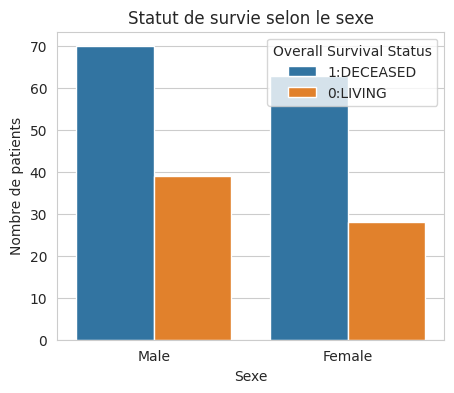

In [10]:
# Sexe (=variable catégorielle)
plt.figure(figsize=(5,4))
sns.countplot(
    x='Sex',
    hue='Overall Survival Status',
    data=df
)
plt.title("Statut de survie selon le sexe")
plt.xlabel("Sexe")
plt.ylabel("Nombre de patients")
plt.show()


L’analyse du statut de survie selon le sexe ne met pas en évidence de différence marquée entre les hommes et les femmes. Cette observation est cohérente avec les données cliniques en hématologie, où le sexe n’est généralement pas considéré comme un facteur pronostique majeur, comparativement à l’âge ou aux altérations génomiques

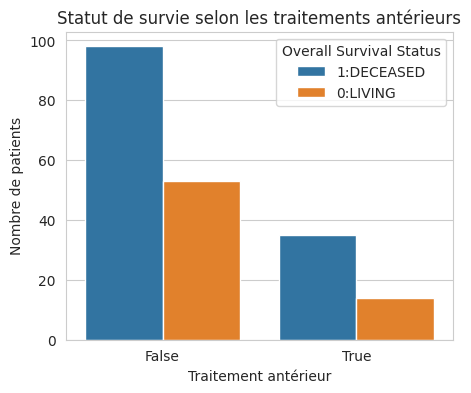

In [11]:
# traitement antérieur (=variable catégorielle)
plt.figure(figsize=(5,4))
sns.countplot(
    x='Prior Treatment',
    hue='Overall Survival Status',
    data=df
)
plt.title("Statut de survie selon les traitements antérieurs")
plt.xlabel("Traitement antérieur")
plt.ylabel("Nombre de patients")
plt.show()


Les patients ayant reçu un traitement antérieur présentent une proportion plus élevée de décès. Cette observation est cohérente avec la pratique clinique en hématologie, où les patients prétraités correspondent souvent à des formes plus avancées ou réfractaires de la maladie, associées à un pronostic défavorable.

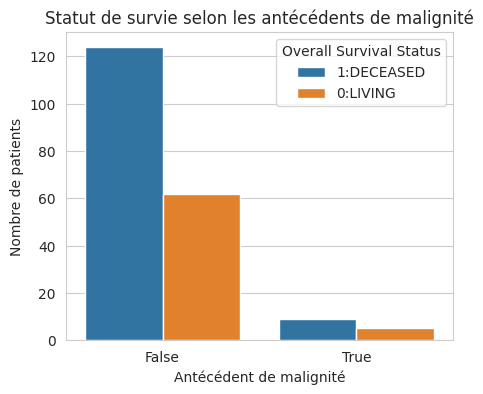

In [12]:
# antécédant de malignité
plt.figure(figsize=(5,4))
sns.countplot(
    x='Prior Malignancy',
    hue='Overall Survival Status',
    data=df
)
plt.title("Statut de survie selon les antécédents de malignité")
plt.xlabel("Antécédent de malignité")
plt.ylabel("Nombre de patients")
plt.show()


Les patients présentant un antécédent de malignité semblent avoir une proportion plus élevée de décès. Toutefois, le faible effectif de cette sous-population limite la portée de cette observation et appelle à une interprétation prudente.

L’analyse exploratoire des données cliniques de patients atteints de leucémie aiguë myéloïde a permis d’identifier plusieurs variables pertinentes pour la prédiction du statut de survie globale.

L’étude de la variable cible met en évidence un déséquilibre modéré entre les patients décédés et vivants, justifiant l’utilisation de métriques adaptées lors de la phase de modélisation.

L’analyse des variables numériques montre que l’âge au diagnostic, la charge mutationnelle et la fraction du génome altéré présentent des distributions différentes selon le statut de survie, suggérant un potentiel intérêt pronostique. Ces résultats sont cohérents avec les connaissances cliniques actuelles en hématologie, où ces facteurs sont fréquemment associés à l’évolution de la maladie.

Concernant les variables catégorielles, le sexe ne semble pas constituer un facteur discriminant majeur, tandis que la variable Prior Treatment apparaît fortement associée à un pronostic défavorable, reflétant probablement des formes plus avancées ou réfractaires de la maladie. La variable Prior Malignancy montre également une tendance vers une survie diminuée, bien que le faible effectif de cette sous-population impose une interprétation prudente.

Dans l’ensemble, cette analyse exploratoire a permis de sélectionner un ensemble restreint de variables cliniquement pertinentes et exploitables pour la modélisation. Ces variables seront utilisées lors de l’étape suivante de préprocessing et de préparation des données, en portant une attention particulière à la gestion des valeurs manquantes, à l’encodage des variables catégorielles et à la prévention du data leakage.